In [733]:
from qutip import qload
from sympy.physics.secondquant import *
from sympy import symbols
import sympy as sp
from cosmatrix import expm_pade

In [776]:
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def create_custom_matrix(N, dim):
    # Initialize a dim x dim matrix with zeros
    matrix = np.zeros((2*dim+1, 2*dim+1))

    # Set the specified elements to 1
    for k in range(2*dim+1):
        if k  + N < 2*dim+1:
            matrix[k][k + N] = 1

    return matrix
def create_diagonal_matrix(dim, ng, Ec):
    # Initialize a dim x dim matrix with zeros
    matrix = np.zeros((2*dim+1, 2*dim+1))

    # Set the diagonal elements as per the given formula
    for k in range(2*dim+1):
        matrix[k][k] = 4 * Ec * ((k-dim)/N- ng)**2

    return matrix
def charge_op(dim, ng, Ec):
    # Initialize a dim x dim matrix with zeros
    matrix = np.zeros((2*dim+1, 2*dim+1))

    # Set the diagonal elements as per the given formula
    for k in range(2*dim+1):
        matrix[k][k] =   ((k-dim)/N- ng)
    return matrix
def SNAIL_charge(phi_ex,beta,N,Ej,Ec,ncut):
    ng=0
    dim = 250
    phi_ex = 2*phi_ex*np.pi
    U = beta*np.exp(1j*phi_ex)*create_custom_matrix(N, dim)+N*create_custom_matrix(1, dim)
    U = U + np.transpose(U.conjugate())
    K = 4*Ec*charge_op(dim, ng, Ec)@charge_op(dim, ng, Ec)
    H = K-Ej*U/2
    energy,U = np.linalg.eigh(H)
    U_dag = np.transpose(U.conjugate())
    energy = energy-energy[0]*np.ones(len(energy))
    charge = U_dag@charge_op(dim, ng, Ec)@U
    H = U_dag@H@U
    return (H - H[0][0]*np.identity(dim*2+1))[:ncut-1,:ncut-1],charge[:ncut-1,:ncut-1]

def SNAIL_oscillator(phi_ex,beta,N,Ej,Ec,ncut):
    sdim = 10
    phi_ex = 2*np.pi*phi_ex
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    g2 = Ej*phi_zpf**2*c2/2
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,U = np.linalg.eigh(Hs)
    U_dag = np.conjugate(U.transpose())
    Hs = U_dag@Hs@U
    return (Hs-energy[0]*np.identity(sdim))[:ncut-1,:ncut-1],(U_dag@(-1j*(s-sd))@U)[:ncut-1,:ncut-1]

def SNAIL_trunc(phi_ex,beta,N,Ej,Ec,ncut):
    phi_ex = phi_ex*2*np.pi
    sdim = 15
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-3*np.cos((phi)/3))
    phi_min = sci.optimize.minimize(U_s,0).x
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    sevend = ad.grad(sixd)
    eightd = ad.grad(sevend)
    c2 = secondd(phi_min[0])
    c3 = thirdd(phi_min[0])/3/2
    c4 = fourd(phi_min[0])/4/3/2
    c5 = fived(phi_min[0])/5/4/3/2
    c6 = sixd(phi_min[0])/6/5/4/3/2
    c7 = sevend(phi_min[0])/7/6/5/4/3/2
    c8 = eightd(phi_min[0])/8/7/6/5/4/3/2
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3
    g4 = Ej*phi_zpf**4*c4
    g5 = Ej*phi_zpf**5*c5
    g6 = Ej*phi_zpf**6*c6
    g7 = Ej*phi_zpf**7*c7
    g8 = 1.5*Ej*phi_zpf**8*c8
    
    s = annihilation(sdim)
    sd = creation(sdim)
    Hs = omega_s * np.matmul(sd,s)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
    x7 = np.matmul(s+sd,x6)
    x8 = np.matmul(s+sd,x7)
    Hs += g3*x3 + g4*x4 + g5*x5 + g6*x6 +1e-10*x8
    energy,U = np.linalg.eigh(Hs)
    U_dag = np.conjugate(U.transpose())
    Hs = Hs
    return (Hs-energy[0]*np.identity(sdim))[:ncut-1,:ncut-1],(-1j*(s))[:ncut-1,:ncut-1],1j*sd,c2


def SNAIL_swt(phi_ex,beta,N,Ej,Ec,ncut):
    phi_ex = phi_ex*2*np.pi
    sdim = 10
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-3*np.cos((phi)/3))
    phi_min = sci.optimize.minimize(U_s,0).x
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    sevend = ad.grad(sixd)
    eightd = ad.grad(sevend)
    c2 = secondd(phi_min[0])
    c3 = thirdd(phi_min[0])/3/2
    c4 = fourd(phi_min[0])/4/3/2
    c5 = fived(phi_min[0])/5/4/3/2
    c6 = sixd(phi_min[0])/6/5/4/3/2
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3
    g4 = Ej*phi_zpf**4*c4
    g5 = Ej*phi_zpf**5*c5
    g6 = Ej*phi_zpf**6*c6
    
    s = annihilation(sdim)
    sd = creation(sdim)
    Hs = (omega_s+12*g4-60*g3**2/omega_s)*sd@s
    a = (24*g4/omega_s-272*g3**2/omega_s**2)*omega_c**2/(omega_c**2-omega_s**2)
    z1 = 2*omega_s/(omega_c**2-omega_s**2)*(1+a)
#     ec_plug(g3,g4,omega_s,omega_c)*g_int**2+omega_c,
    return  ec_plug(g3,g4,omega_s,omega_c)*g_int**2+omega_c
    
def composite_spec(Hs, Vs, g_int,omega_c):
    sdim = len(Hs[0])
    cdim = 15
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    s,sd = Vs
    H_int = g_int*np.kron(s,(cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    index = np.argmin(np.abs(energy-omega_c*np.ones(len(energy))))
    exact = energy[index]
    return exact

In [777]:
beta = 0.12
N = 3
ncut=100
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
omega_c = 4*2*np.pi
phi_ex_values = np.linspace(0.4,0.43, 50)
# phi_ex_values = np.linspace(.485, 0.5, 10)
composite_spec_results1 = []
composite_spec_results2 = []
composite_spec_results3 = []
composite_spec_results4 = []
composite_spec_results5 = []
composite_spec_results6 = []
snail_freq1 = []
snail_freq2 = []
snail_anh1 = []
snail_anh2 = []
snail_anh3 = []
for phi_ex in phi_ex_values:
    H1,  s,sd,c2 = SNAIL_trunc(phi_ex, beta, N, Ej, Ec, ncut)
    g_int = 0.15*2*np.pi*c2**0.25
    snail_freq1.append(H1[1][1]/2/np.pi)
    snail_anh1.append(H1[2][2]/2/np.pi - 2*H1[1][1]/2/np.pi )
    
    result = composite_spec(H1, (s,sd), g_int, omega_c) / (2 * np.pi)
    composite_spec_results1.append(result)
    phi_zpf = (2*Ec/Ej/c2)**0.25
    H1, V1= SNAIL_charge(phi_ex, beta, N, Ej, Ec, ncut)
    H1 = np.real(H1)
    snail_freq2.append(H1[1][1]/2/np.pi)
    snail_anh2.append(H1[2][2]/2/np.pi - 2*H1[1][1]/2/np.pi )
#     result4= composite_spec(H1, V1*2*phi_zpf, g_int, omega_c) / (2 * np.pi)
#     composite_spec_results4.append(result4)
    result5= SNAIL_swt(phi_ex,beta,N,Ej,Ec,ncut)
    snail_anh3.append(result5)
    composite_spec_results5.append(result5/2/np.pi)
    
    H1, V1= SNAIL_oscillator(phi_ex, beta, N, Ej, Ec, ncut)
#     result3 = composite_spec(H1, V1, g_int, omega_c) / (2 * np.pi)
#     composite_spec_results3.append(result3)
    # Plotting


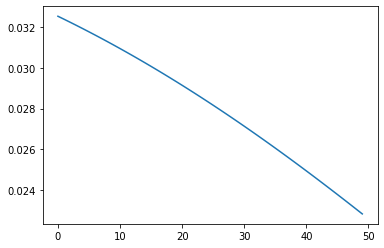

In [778]:
# plt.plot(np.array(snail_anh1 ))
# plt.plot(np.array(snail_anh2 ))
# plt.plot(np.array(snail_anh3 )/np.pi)
plt.plot(np.array(snail_freq1 )-np.array(snail_freq2 ))

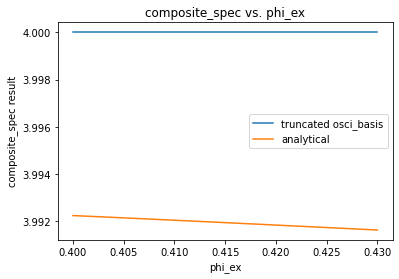

In [779]:
plt.plot(phi_ex_values, np.array(composite_spec_results1), label='truncated osci_basis')
# plt.plot(phi_ex_values, np.array(composite_spec_results2), label='2nd swt')
# plt.plot(phi_ex_values[:], np.array(composite_spec_results3), label='osc_basis')
# plt.plot(phi_ex_values[:], np.array(composite_spec_results4))
plt.plot(phi_ex_values, np.array(composite_spec_results5), label='analytical')
# plt.ylim(omega_c/2/np.pi,omega_c/2/np.pi+0.025)
plt.xlabel('phi_ex')
plt.ylabel('composite_spec result')
plt.title('composite_spec vs. phi_ex')
plt.legend()
plt.show()

In [771]:
np.array(composite_spec_results1)

array([3.99226573, 3.99225407, 3.99224236, 3.99223062, 3.99221883,
       3.99220701, 3.99219515, 3.99218325, 3.99217131, 3.99215933,
       3.99214732, 3.99213527, 3.99212319, 3.99211107, 3.99209892,
       3.99208673, 3.99207451, 3.99206226, 3.99204997, 3.99203766,
       3.99202531, 3.99201294, 3.99200054, 3.9919881 , 3.99197565,
       3.99196316, 3.99195065, 3.99193811, 3.99192555, 3.99191297,
       3.99190037, 3.99188774, 3.99187509, 3.99186243, 3.99184975,
       3.99183705, 3.99182433, 3.9918116 , 3.99179886, 3.9917861 ,
       3.99177333, 3.99176055, 3.99174776, 3.99173497, 3.99172217,
       3.99170936, 3.99169655, 3.99168373, 3.99167092, 3.9916581 ])

In [657]:
import qutip as qt
expr = qt.qload('./anh')
def anh_plug(g3v,g4v,g5v,g6v,omega_sv):
    expr = qload('./anh')
    from sympy import symbols
    g3 = symbols('g3', real=True)
    g4 = symbols('g4', real=True)
    g5 = symbols('g5', real=True)
    g6 = symbols('g6', real=True)
    omega_a = symbols('omega', real=True)
    return float(expr.subs(g3,g3v).subs(g4,g4v).subs(omega_a,omega_sv).subs(g5,g5v).subs(g6,g6v))

In [693]:
import qutip as qt
expr = qt.qload('./ect')
def ec_plug(g3v,g4v,omega_sv,omega_cv):
    expr = qload('./ect')
    from sympy import symbols
    g3 = symbols('g3', real=True)
    g4 = symbols('g4', real=True)
    g5 = symbols('g5', real=True)
    g6 = symbols('g6', real=True)
    omega_a = symbols('w_s', real=True)
    omega_b = symbols('omega_c', real=True)
    eta = symbols('eta',real = False)
    return float(expr.subs(g3,g3v).subs(g4,g4v).subs(omega_a,omega_sv).subs(omega_b,omega_cv).subs(eta,0))

In [694]:
expr

-81*eta*g3**2*w_s*conjugate(eta)/(omega_c**2*w_s**2 + 2*omega_c*w_s**3 + w_s**4) - 9*eta*g3**2*conjugate(eta)/(2*omega_c**2*w_s + 4*omega_c*w_s**2 + 2*w_s**3) - 9*eta*g3**2*conjugate(eta)/(2*omega_c**2*w_s - 4*omega_c*w_s**2 + 2*w_s**3) - 81*eta*g3**2*conjugate(eta)/(omega_c**2*w_s - 2*omega_c*w_s**2 + w_s**3) + 693*eta*g3**2*conjugate(eta)/(w_s*(8*omega_c*w_s + 8*w_s**2)) - 171*eta*g3**2*conjugate(eta)/(w_s*(2*omega_c*w_s - 2*w_s**2)) + 9*eta*g3**2*conjugate(eta)/(w_s*(-8*omega_c*w_s - 8*w_s**2)) + 24*eta*g4*w_s**2*conjugate(eta)/(omega_c**2*w_s**2 + 2*omega_c*w_s**3 + w_s**4) + 24*eta*g4*conjugate(eta)/(omega_c**2 - 2*omega_c*w_s + w_s**2) + 24*eta*g4*conjugate(eta)/(omega_c*w_s - w_s**2) + 24*eta*g4*conjugate(eta)/(-omega_c*w_s - w_s**2) - 60*g3**2*w_s/(omega_c**2*w_s**2 + 2*omega_c*w_s**3 + w_s**4) - 60*g3**2/(omega_c**2*w_s - 2*omega_c*w_s**2 + w_s**3) + 76*g3**2/(w_s*(omega_c*w_s + w_s**2)) - 76*g3**2/(w_s*(omega_c*w_s - w_s**2)) + 32*g3**2/(w_s*(omega_c*w_s - 2*w_s**2)) + 32*g3*